## **LunarLander con Neuroevolución**
Entrenamiento de una red neuronal mediante Computación Evolutiva. Se hace uso de un Algoritmo Genético Evolucional. Se evolucionan los pesos de la red. Un individuo tiene X cromosomas, cada uno de ellos representa un peso del modelo, con una arquitectura interna de capas [8,X,4].

El fitness un agente es el refuerzo acumulativo de una partida LunarLander. Como el entorno es cambiante, para cada individuo se entrenan varios escenarios, y se toma como refuerzo el promedio. Es conveniente usar aplicar un multiarranque, aunque por ahora no se usa por el elevado tiempo de ejecución. 

In [1]:
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="rgb_array")

import numpy as np
import pygame
import gymnasium.utils.play
from MLP import MLP
import random
import loky
from loky import get_reusable_executor
import itertools
import multiprocessing

lunar_lander_keys = {
    (pygame.K_UP,): 2,
    (pygame.K_LEFT,): 1,
    (pygame.K_RIGHT,): 3,
}

print(f"Nucleos: {multiprocessing.cpu_count()}")

Nucleos: 8


### Tareas
1. Probar nuevas politicas
2. Nuevos operadores: crossover, mutacion
3. Cambio de arquitectura [8, X, 4]. 2,6,20
4. Graficas: 
    - mejor fitness en funcion de generaciones
    - fitness medio (de poblacion) en funcion de generaciones
    - Precision (numero de aterrizajes correctos en cada iteracion) // hay que obtener "algun indicativo de que aterrice bien" 

**Políticas y run()**

In [18]:
def policy_base (observation, model):
    s = model.forward(observation)
    action = np.argmax(s)
    return action


def policy_epsGreedy(observation, model):
    epsilon = 0.10
    s = model.forward(observation)
    if np.random.rand() < epsilon:
        action = np.random.randint(len(s))
    else:
        action = np.argmax(s)
    return action


def policy_softmax(observation, model, tau=1.0):
    s = model.forward(observation)  # Paso 1: Obtener valores Q estimados
    probabilities = np.exp(s / tau) / np.sum(np.exp(s / tau))  # Paso 2: Calcular las probabilidades
    action = np.random.choice(len(s), p=probabilities)  # Paso 3: Elegir una acción basada en la distribución
    return action


def run (model):
    # observation, info = env.reset(seed=42)
    observation, info = env.reset()
    ite = 0
    racum = 0
    while True:
        action = policy_softmax(observation, model)
        observation, reward, terminated, truncated, info = env.step(action)
        
        racum += reward

        if terminated or truncated:
            # r = (racum+200) / 500
            # print(racum, r)
            return racum


def run_multiple_games(ch, arquitecture, N_games):

    model = MLP(arquitecture)
    model.from_chromosome(ch)

    r = 0

    for _ in range(N_games):
        r += run(model)
    
    return r/N_games # devuelve el refuerzo medio

**Mutate**

In [14]:
def mutate(ind, pmut, rang):
    if random.random() < pmut:
        idx = random.randint(0, len(ind) - 1)
        ind[idx] = random.uniform(rang[0], rang[1])
    return ind.copy()


def mutateAll(ind, pmut, rang):
    if random.random() < pmut:
        for i in range(len(ind)):
            ind[i] = random.uniform(rang[0], rang[1])
    return ind.copy()


def mutate_gaussian(ind, pmut, mutation_power=0.002):
    if random.random() < pmut:
        for i in range(len(ind)):
            # distribución normal
            noise = np.random.normal(0, mutation_power)  # Media = 0, desviación estándar = mutation_power
            ind[i] += noise
        return ind.copy()
    else:
        return ind.copy()


def mutate_gaussian_cromosoma(ind, pmut, mutation_power=0.2):
    
    for i in range(len(ind)):
        if random.random() < pmut:
            # distribución normal
            noise = np.random.normal(0, mutation_power)  # Media = 0, desviación estándar = mutation_power
            ind[i] += noise
        return ind.copy()
    else:
        return ind.copy()


def mutate_gaussian2(ind, pmut, rang):
    if random.random() < pmut:
        ind = [gen + random.uniform(-1, 1) for gen in ind]
    return ind.copy()

**Crossovers**

In [15]:
def crossover_lineal (ind1, ind2, pcross, arquitecture): # devuelve el cruce (emparejamiento) de dos individuos, considerando todos los genes
    if (random.random() > pcross):
        return ind1.copy(), ind2.copy()
    child1 = []
    child2 = []

    for gene1, gene2 in zip(ind1, ind2):
        beta = random.uniform(0, 1)
        c1 = beta * gene1 + (1 - beta) * gene2
        c2 = (1 - beta) * gene1 + beta * gene2
        
        child1.append(c1)
        child2.append(c2)
    
    return child1, child2
    
    
def crossoverAlpha(parent1, parent2, pcross):
    """BLX-alpha crossover. Return two children"""
    alpha = 0.5
    if random.random() < pcross:
        child1 = []
        child2 = []
        for gene1, gene2 in zip(parent1, parent2):
            
            x_min = min(gene1, gene2)
            x_max = max(gene1, gene2)
            I = x_max - x_min
            
            lower_bound = x_min - alpha * I
            upper_bound = x_max + alpha * I
            
            c1 = random.uniform(lower_bound, upper_bound)
            c2 = random.uniform(lower_bound, upper_bound)
            child1.append(c1)
            child2.append(c2)
        return child1, child2
    else:
        return parent1, parent2

In [16]:
rang = (-5, 5)
createRang = (-5, 5)

def select(pop, T, fitness_array): 
    tournament = random.sample(range(len(pop)), T)  
    # Busca el índice del mejor individuo (mayor fitness porque es acumulativo en LunarLander)
    best_index = max(tournament, key=lambda i: fitness_array[i])  
    return pop[best_index].copy()  


def create(createRang, arquitecture, N=100): 
    pop = []
    
    print(f"--- Creacion de poblacion: Individuos = {100}, Rango = {createRang}")

    cromosoma_length = (arquitecture[0] * arquitecture[1]) + arquitecture[1] + (arquitecture[1] * arquitecture[2]) + arquitecture[2]

    for _ in range(N):
        values = [random.uniform(createRang[0], createRang[1]) for _ in range(cromosoma_length)]  
        pop.append(values)

    return pop


def sort_pop (pop, fitness): 

    aux_pop = pop
    aux_fitness = fitness

    pop_with_fitness = [(indiv, fit) for indiv, fit in zip(aux_pop, aux_fitness)]
    sorted_pop = sorted(pop_with_fitness, key=lambda x: x[1], reverse=True)  # Mayor fitness primero
    return [indiv for indiv, _ in sorted_pop], [fit for _, fit in sorted_pop]

    


def evolve_gen(pop, rangMut, pmut,  arquitecture = [8,6,4], generations = 6000, T=2, trace=100, pcross=0.7, elitism=False, N_games=2, n_elitism=0):
    
    print(f"Parámetros: pmut = {pmut}, Rango de Mutacion = {rangMut}, arquitecture = {arquitecture}, generations = {generations}, T = {T}, pcross = {pcross}, elitism = {elitism}, N_games = {N_games}, n_elitism = {n_elitism}")
    
    max_fitness_perGeneration = []
    mean_fitness_perGeneration = []
    min_fitness_perGeneration = []

    generation = 0
    executor = get_reusable_executor()

    
    while generation < generations:
        new_poblacion = []

        fitness_array = list(executor.map(run_multiple_games, pop, itertools.repeat(arquitecture), itertools.repeat(N_games)))
        generation += 1

        pop, fitness = sort_pop(pop, fitness_array)
     

        max_fitness_perGeneration.append(fitness[0])
        mean_fitness_perGeneration.append(np.array(fitness).mean())
        min_fitness_perGeneration.append(fitness[-1])

        if trace > 0 and generation % trace == 0:
            print(f"Generacion: {generation}, Mejor fitness: {fitness[0]}")
            
        if generation >= generations:
            break

        if elitism:
            #new_poblacion.append(pop[0].copy())
            new_poblacion.extend([ind.copy() for ind in pop[:n_elitism]])

        while len(new_poblacion) < len(pop):
            parent_1 = select(pop, T, fitness)
            parent_2 = select(pop, T, fitness)

            child_1, child_2 = crossover_lineal(parent_1, parent_2, pcross, arquitecture)

            m1 = mutate_gaussian(child_1, pmut)
            m2 = mutate_gaussian(child_2, pmut)

            new_poblacion.extend([m1, m2])

        pop = new_poblacion[:len(pop)].copy()

    print(f"Generacion: {generation}, Mejor fitness: {fitness[0]}")
    
    return pop, fitness, max_fitness_perGeneration, mean_fitness_perGeneration, min_fitness_perGeneration


In [17]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.2")
    rangMutacion = (-5, 5)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=4, trace=50, pcross=0.7, elitism=False, N_games=2)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.2
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-5, 5), arquitecture = [8, 6, 4], generations = 400, T = 4, pcross = 0.7, elitism = False, N_games = 2, n_elitism = 0


KeyboardInterrupt: 

> *Rango de mutacion (-5,5) , aplicando la probabilidad individualmente a cada cromosoma devuelve mal resultado* 

In [ ]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=8, trace=50, pcross=0.7, elitism=False, N_games=2)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 400, T = 8, pcross = 0.7, elitism = False, N_games = 2
Generacion: 50, Mejor fitness: -8.602792415994756
Generacion: 100, Mejor fitness: -7.091135872194307
Generacion: 150, Mejor fitness: 6.343020978289843
Generacion: 200, Mejor fitness: 31.62166068345369
Generacion: 250, Mejor fitness: -15.135895750204451
Generacion: 300, Mejor fitness: 21.284227267986182
Generacion: 350, Mejor fitness: -8.383864553053343


c:\Users\34627\anaconda3\Lib\site-packages\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Generacion: 400, Mejor fitness: 0.38977283359117365
Generacion: 400, Mejor fitness: 0.38977283359117365


> *Rango de mutacion (-1,1) aplicando probabilidad individualmente a cada cromosoma devuelve mal resultado, per mejora los resultados respecto el rango (-5,5)* 

In [ ]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.2")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=1000, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. mutate gaussiano 1
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 1000, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: 35.44676429606502
Generacion: 100, Mejor fitness: 31.96727883700095
Generacion: 150, Mejor fitness: 77.67674347371837
Generacion: 200, Mejor fitness: 149.68569329361395
Generacion: 250, Mejor fitness: 163.4644302568507
Generacion: 300, Mejor fitness: 153.92880372849655
Generacion: 350, Mejor fitness: 153.56635495328422
Generacion: 400, Mejor fitness: 173.11246056759626
Generacion: 450, Mejor fitness: 162.0995254050241
Generacion: 500, Mejor fitness: 156.9085126690114
Generacion: 550, Mejor fitness: 270.31772645258417
Generacion: 600, Mejor fitness: 162.19891105723715
Generacion: 650, Mejor fitness: 251.40935427932422
Generacion: 700, Mejor fitness: 179.27604003020147
Generaci

> *La mutacion gaussiana con 0.2 mejora mucho los resultados. El elitismo mejora bastante los resultados.* 

In [ ]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.11")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=600, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.11
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 600, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: -47.019349209845224
Generacion: 100, Mejor fitness: -31.44903386529936
Generacion: 150, Mejor fitness: 1.7223346463012301
Generacion: 200, Mejor fitness: -17.49754473433568
Generacion: 250, Mejor fitness: -16.688389778283508
Generacion: 300, Mejor fitness: -16.172501376144115
Generacion: 350, Mejor fitness: 45.83633067604154
Generacion: 400, Mejor fitness: 6.023375262081558
Generacion: 450, Mejor fitness: 76.54928362882212
Generacion: 500, Mejor fitness: -8.24912612071057


KeyboardInterrupt: 

> *Con 0.11 devuelve mal resultado, peor que con 0.2* 

In [ ]:
# lo mejor de las dos pruebas previas pero con un mutate que no aplique a todo el individuo con todos sus cromosomas, solo uno
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. mutate gaussiano 1 que solo aplica a un cromosoma con un 0.2 ")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=600, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. mutate gaussiano 1 que solo aplica a un cromosoma con un 0.2 
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 600, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: -7.420641077052451
Generacion: 100, Mejor fitness: 1.1828041400962992
Generacion: 150, Mejor fitness: 15.386187587163642
Generacion: 200, Mejor fitness: -4.894865592410525
Generacion: 250, Mejor fitness: 15.284771009336135
Generacion: 300, Mejor fitness: -11.964340333538182
Generacion: 350, Mejor fitness: 16.19611911124308
Generacion: 400, Mejor fitness: -2.324722481069358
Generacion: 450, Mejor fitness: 50.4547973002848
Generacion: 500, Mejor fitness: 58.669649824389204
Generacion: 550, Mejor fitness: 59.34246596451643
Generacion: 600, Mejor fitness: 0.2734003816292301
Generacion: 600, Mejor fitness: 0.2734003816292301


In [ ]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.5")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=500, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.2
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 500, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: 11.422957142116479
Generacion: 100, Mejor fitness: 67.61561840971814
Generacion: 150, Mejor fitness: 76.01256529432908
Generacion: 200, Mejor fitness: 57.123378178389935
Generacion: 250, Mejor fitness: 147.09967696905167
Generacion: 300, Mejor fitness: 83.20467379905914
Generacion: 350, Mejor fitness: 100.90866621151406
Generacion: 400, Mejor fitness: 84.37204777723345
Generacion: 450, Mejor fitness: 178.54690527999182
Generacion: 500, Mejor fitness: 93.12528786425844
Generacion: 500, Mejor fitness: 93.12528786425844


> con gaussiano 0.5 mal resultado, peor que con 0.2

In [ ]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.002")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=500, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.002
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 500, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: 65.28758829852119
Generacion: 100, Mejor fitness: 89.37999009918212
Generacion: 150, Mejor fitness: -0.0038042584895663367
Generacion: 200, Mejor fitness: 21.566102888642558
Generacion: 250, Mejor fitness: -6.025721989972747
Generacion: 300, Mejor fitness: 35.00274684683086
Generacion: 350, Mejor fitness: 61.24328306919756
Generacion: 400, Mejor fitness: 19.393631314960416
Generacion: 450, Mejor fitness: 86.83538111534205
Generacion: 500, Mejor fitness: 78.44051684660332
Generacion: 500, Mejor fitness: 78.44051684660332


> con 0.002 peor resultado que con 0.2 en gaussiano

> **A partir de aqui se prueba con el modelo con elitismo con gaussiano de 0.2 que devuelve mejores resultados**

In [19]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: softmax con tau 1. mutate gaussiano 1 con un 0.2")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=1000, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: softmax con tau 1. mutate gaussiano 1 con un 0.2
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 1000, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: -37.16841314385219
Generacion: 100, Mejor fitness: -54.194679644311385
Generacion: 150, Mejor fitness: -74.1731876751637


KeyboardInterrupt: 

crossoveralpha
--- 

In [57]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate")
    rangMutacion = (-0.5, 0.5)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=8, trace=50, pcross=0.7, elitism=False, N_games=3)

    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-0.5, 0.5), arquitecture = [8, 6, 4], generations = 400, T = 8, pcross = 0.7, elitism = False, N_games = 3, n_elitism = 0
Generacion: 50, Mejor fitness: -35.999008696320644
Generacion: 100, Mejor fitness: 10.098202348063362
Generacion: 150, Mejor fitness: 21.45269884831161
Generacion: 200, Mejor fitness: 72.04829206392701


c:\Users\34627\anaconda3\Lib\site-packages\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Generacion: 250, Mejor fitness: 35.56249142596106
Generacion: 300, Mejor fitness: 70.87306877110888


KeyboardInterrupt: 

> *el crossalpha mejora, se mantiene el mutate de un solo cromosoma. La siguiente prueba deberia probar el elitismo para comparar* 

In [59]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. CrossoverAlpha. MutateAll")
    rangMutacion = (-0.5, 0.5)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=8, trace=50, pcross=0.7, elitism=False, N_games=3)

    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. CrossoverAlpha. MutateAll
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-0.5, 0.5), arquitecture = [8, 6, 4], generations = 400, T = 8, pcross = 0.7, elitism = False, N_games = 3, n_elitism = 0
Generacion: 50, Mejor fitness: -58.752105667000144
Generacion: 100, Mejor fitness: -72.73072680015183
Generacion: 150, Mejor fitness: -74.73886385553304
Generacion: 200, Mejor fitness: -46.977320375974976
Generacion: 250, Mejor fitness: -66.19552148259136
Generacion: 300, Mejor fitness: -71.2861971843973
Generacion: 350, Mejor fitness: -42.50070383600472
Generacion: 400, Mejor fitness: -62.88089714699775
Generacion: 400, Mejor fitness: -62.88089714699775


> *Manteniendo el crossalpha, se cambia el mutate por mutateall que se aplica a todos los cromosoomas de un individuo, EMPEORAN LOS RESULTADOS MUCHO* 

In [61]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate")
    rangMutacion = (-0.5, 0.5)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=8, trace=50, pcross=0.7, elitism=False, N_games=3)

    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-0.5, 0.5), arquitecture = [8, 6, 4], generations = 400, T = 8, pcross = 0.7, elitism = False, N_games = 3, n_elitism = 0
Generacion: 50, Mejor fitness: 11.432450123791588
Generacion: 100, Mejor fitness: 35.83892556032425
Generacion: 150, Mejor fitness: 9.02435066516919
Generacion: 200, Mejor fitness: 2.8504486365466923
Generacion: 250, Mejor fitness: 62.04690986405573
Generacion: 300, Mejor fitness: 72.76156280751097


KeyboardInterrupt: 

In [ ]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate gaussiano 2")
    rangMutacion = (-0.5, 0.5)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=8, trace=50, pcross=0.7, elitism=False, N_games=3)

    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate gaussiano All
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-0.5, 0.5), arquitecture = [8, 6, 4], generations = 400, T = 8, pcross = 0.7, elitism = False, N_games = 3, n_elitism = 0
Generacion: 50, Mejor fitness: -4.915456933878223
Generacion: 100, Mejor fitness: -34.61324409498328
Generacion: 150, Mejor fitness: -32.40524920818418
Generacion: 200, Mejor fitness: -15.443642009884522
Generacion: 250, Mejor fitness: -24.28136540045973
Generacion: 300, Mejor fitness: -10.595542953064347


KeyboardInterrupt: 

In [88]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate triple")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=8, trace=50, pcross=0.7, elitism=False, N_games=3)

    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate triple
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 400, T = 8, pcross = 0.7, elitism = False, N_games = 3, n_elitism = 0
Generacion: 50, Mejor fitness: 0.02952045459085184
Generacion: 100, Mejor fitness: -15.326143635847123
Generacion: 150, Mejor fitness: -21.081548063272013
Generacion: 200, Mejor fitness: 2.6043902042711458
Generacion: 250, Mejor fitness: 7.967132263500162
Generacion: 300, Mejor fitness: -1.4893433565615055
Generacion: 350, Mejor fitness: 20.337148389514415
Generacion: 400, Mejor fitness: 51.098913352936385
Generacion: 400, Mejor fitness: 51.098913352936385


In [100]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate triple")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=400, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)

    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. CrossoverAlpha. Mutate triple
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 400, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: 123.10252267870032
Generacion: 100, Mejor fitness: 180.4221240925223
Generacion: 150, Mejor fitness: 256.6404650616178


KeyboardInterrupt: 

### **Plot**

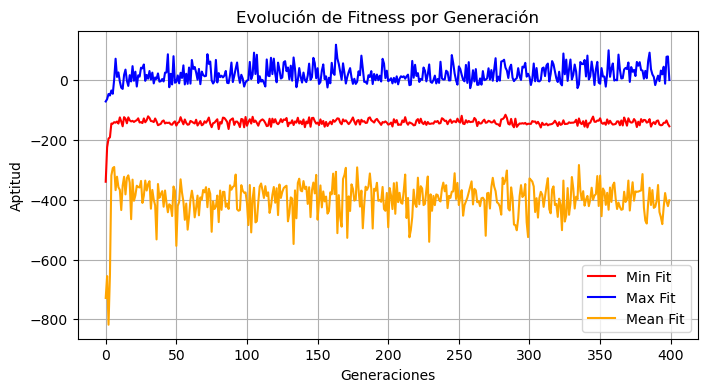

In [33]:
# Celda de Código de grafica para los fitness (min, max, mean)
import matplotlib.pyplot as plt

%matplotlib inline

generations = list(range(0,400))
plt.figure(figsize=(8,4))

plt.plot(list(generations), list(f_min), label='Min Fit', color='red', linestyle='-')
plt.plot(list(generations), list(f_max), label='Max Fit', color='blue', linestyle='-')
plt.plot(list(generations), list(f_mean), label='Mean Fit', color='orange', linestyle='-')

plt.xlabel('Generaciones')
plt.ylabel('Aptitud')
plt.title('Evolución de Fitness por Generación')

plt.legend()

plt.grid(True)
plt.show()


---

In [ ]:
import time

def run_lunar_lander(model, chromosome):

    env = gym.make("LunarLander-v3", render_mode="human")  
    observation, _ = env.reset() 
    model.from_chromosome(chromosome)  
    
    total_reward = 0
    done = False

    while not done:
        env.render()  
        
        action_values = model.forward(observation)  
        action = np.argmax(action_values)  
        
        observation, reward, done, _, _ = env.step(action)  
        total_reward += reward
        
        time.sleep(0.05)  
    
    env.close()
    print(f"Total reward: {total_reward}")

arquitecture = [8, 6, 4] 
model = MLP(arquitecture)


# 🔹 Ejecutar el modelo en el entorno
run_lunar_lander(model, best_individuals[0])
